In [1]:
import os
# Move to Thesis directory (two levels up)
os.chdir(os.path.abspath(os.path.join("..", "..")))

# Move to model/src if it exists
model_dir = os.path.join(os.getcwd(), "model", "src")
if os.path.exists(model_dir):
    os.chdir(model_dir)

print("Current Directory:", os.getcwd())

Current Directory: c:\Users\Utilizador\OneDrive - NOVAIMS\Desktop\github\Thesis\model\src


In [3]:
#%pip install  ragatouille
#%pip install bitsandbytes 
#%pip install sentence-transformers 
#%pip install faiss-cpu
#%pip install pacmap  
#%pip install langchain_community
#%pip install langchain-chroma


In [2]:
import os
from langchain_core.documents import Document
import pickle
import re
import torch

In [3]:
# Load your dictionary from pickle
with open(r"../../data/Preprocessing_text/bachelors_data/dict_studyplan_cleaned.pkl", "rb") as f:
    docs_dict = pickle.load(f)

# Convert to LangChain Documents
documents = [
    Document(page_content=text, metadata={"source": filename})
    for filename, text in docs_dict.items()
]

In [6]:
# Check how many documents were loaded
print(f"Total documents loaded: {len(documents)}")

# Print a sample document (first one)
print("\nSample Document Object:")
print(documents[0])

# Print just the metadata and a preview of content
print("\nMetadata and preview:")
print("Metadata:", documents[0].metadata)
print("Content preview:", documents[0].page_content[:300])  # first 300 chars

Total documents loaded: 3

Sample Document Object:
page_content='Text from https://www.novaims.unl.pt/en///bachelor-s-degrees/data-science/program/#: Program Study Plan en Bachelor's Degrees Data Science Program 1 st year - Fall Semester Course Units Duration Type Contact Hours Total Workload ECTS Computers' Architecture Semester Mandatory TP - 45 | OT - 5 112 4 Foundational aspects of data science Semester Mandatory TP - 45 | OT - 5 112 4 Information Systems Semester Mandatory TP - 64,5 | S - 3 | OT - 7,5 168 6 Introduction to Programming Semester Mandatory TP - 67,5 | OT - 7,5 196 7 Linear Algebra Semester Mandatory T - 22,5 | PL - 22,5 | OT - 7,5 112 4 Show subtitles T – Theoretical Teaching; TP – Theoretical/ Practical Teaching; TC – Field Work; PL – Theoretical/ Practical Teaching; S – Seminar; OT – Tutor Group; ** – Course Unit available in both semesters; 1 st year - Spring Semester Course Units Duration Type Contact Hours Total Workload ECTS Algorithms and Data Structures Semes

# Load all documents in a folder with pickle dictionaries

In [4]:
# Folder where your pickle files are stored
pickle_folder = r"../../data/Preprocessing_text/bachelors_data"

# List to store all LangChain Documents
all_documents = []

# Loop through all files in the folder
for filename in os.listdir(pickle_folder):
    if filename.endswith(".pkl"):
        file_path = os.path.join(pickle_folder, filename)
        with open(file_path, "rb") as f:
            docs_dict = pickle.load(f)
        
        # Convert each key-value pair into a Document object
        documents = [
            Document(page_content=text, metadata={"source": key})
            for key, text in docs_dict.items()
        ]
        
        all_documents.extend(documents)

print(f"Total documents loaded: {len(all_documents)}")
print("Sample document metadata:", all_documents[0].metadata)

Total documents loaded: 9
Sample document metadata: {'source': 'data-science_main_course_extracted_text.txt'}


In [5]:
# Check how many documents were loaded
print(f"Total documents loaded: {len(all_documents)}")

# Print a sample document (first one)
print("\nSample Document Object:")
print(all_documents[0])

# Print just the metadata and a preview of content
print("\nMetadata and preview:")
print("Metadata:", all_documents[0].metadata)
print("Content preview:", all_documents[0].page_content[:300])  # first 300 chars

Total documents loaded: 9

Sample Document Object:
page_content='Text from https://www.novaims.unl.pt/en///bachelor-s-degrees/data-science/: Data Science Degree in Data Science en Bachelor's Degrees Data Science In the Bachelor´s Degree in Data Science, students learn the most modern techniques of artificial intelligence and machine learning to analyze large volumes of data (Big Data). They will become true data scientists - considered the sexiest profession of the 21 st century by the Harvard Business Review. The main objective of this course is to train future professionals capable of understanding, developing and using models, algorithms and the most advanced techniques in data science, to analyze and extract knowledge from Big Data. The 3 rd phase of applications under the International Student Statute for the 2025/26 academic year are open from February 26 th to March 27 th , 2025. Duration 3 years (6 semesters) Timetable Daytime Start September 2025 Career Opportunities The Bache

In [6]:
all_documents

[Document(metadata={'source': 'data-science_main_course_extracted_text.txt'}, page_content="Text from https://www.novaims.unl.pt/en///bachelor-s-degrees/data-science/: Data Science Degree in Data Science en Bachelor's Degrees Data Science In the Bachelor´s Degree in Data Science, students learn the most modern techniques of artificial intelligence and machine learning to analyze large volumes of data (Big Data). They will become true data scientists - considered the sexiest profession of the 21 st century by the Harvard Business Review. The main objective of this course is to train future professionals capable of understanding, developing and using models, algorithms and the most advanced techniques in data science, to analyze and extract knowledge from Big Data. The 3 rd phase of applications under the International Student Statute for the 2025/26 academic year are open from February 26 th to March 27 th , 2025. Duration 3 years (6 semesters) Timetable Daytime Start September 2025 Car

## Chunking

**Bachelors teaching staff example**

In [31]:
def split_teaching_staff_grouped(text, metadata=None, max_token_size=200):
    # Regex pattern to match a block of "Name\nTitle\nEmail"
    pattern = r"([A-Z][a-zA-Zçéàèíóõâêã]+\s+[A-Z][a-zA-Zçéàèíóõâêã]+.*?)\s([\w\.\s]+?)\s([\w\.-]+@novaims\.unl\.pt)"
    matches = re.findall(pattern, text)
    
    grouped_text = ""
    chunks = []
    current_chunk_token_count = 0  # Keep track of the current chunk's token count

    for match in matches:
        name, title, email = match
        professor_info = f"{name}\n{title}\n{email}\n\n"
        
        # Estimate the number of tokens in the new professor info (rough estimate by splitting on space)
        token_count = len(professor_info.split())

        # If adding this professor exceeds the max token size, start a new chunk
        if current_chunk_token_count + token_count > max_token_size:
            if grouped_text:
                # Add the current chunk as a new document and reset
                chunks.append(Document(page_content=grouped_text, metadata=metadata or {}))
                grouped_text = ""  # Reset for the next group
                current_chunk_token_count = 0  # Reset token count for the new chunk
        
        # Add the current professor to the group
        grouped_text += professor_info
        current_chunk_token_count += token_count

    # Add the last chunk if there's any remaining text
    if grouped_text:
        chunks.append(Document(page_content=grouped_text, metadata=metadata or {}))

    return chunks

In [33]:
# Extract the text content from the Document
staff_text = all_documents[6].page_content

# Pass the extracted text to the split function
staff_chunks = split_teaching_staff_grouped(staff_text, metadata={"source": "teaching_staff"})

# Print the number of chunks and the content of the first chunk
print(len(staff_chunks))
print(staff_chunks[0].page_content)

2
Teaching Staff en Programs Bachelor's
Degrees Data Science Teaching Staff Américo Rio Invited Assistant Professor
americo.rio@novaims.unl.pt

Ana Cristina
Costa Associate Professor
cristina@novaims.unl.pt

Artur Varanda
Adjunct Lecturer
avaranda@novaims.unl.pt

Augusto Santos
Assistant Professor
ajrsantos@novaims.unl.pt

Bruno Damásio
Assistant Professor
bdamasio@novaims.unl.pt

Carina Albuquerque
Assistant Professor
calbuquerque@novaims.unl.pt

Carolina Maria
Shaul Adjunct Lecturer
cshaul@novaims.unl.pt

Carolina Santos
Maximiano Adjunct Lecturer
cmaximiano@novaims.unl.pt

Carolina Vasconcelos
Invited Teaching Assistant
cvasconcelos@novaims.unl.pt

Catarina Neves
Assistant Professor
cneves@novaims.unl.pt

Catarina Palha
Invited Teaching Assistant
cpalha@novaims.unl.pt

Dhruv Akshay
Pandit Invited Teaching Assistant
dpandit@novaims.unl.pt

Diogo Rasteiro
Research Assistant
drasteiro@novaims.unl.pt

Fernando Bação
Full Professor
bacao@novaims.unl.pt

Filipe Marques
Professor of the Pr

## Embeddings

To clean cache to fix the error of loop in importing torch: %pip cache purge

In [34]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [35]:
vector_1 = embeddings.embed_query(staff_chunks[0].page_content)
vector_2 = embeddings.embed_query(staff_chunks[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vectors of length {len(vector_1)}\n")
print(vector_1[:10])

Generated vectors of length 768

[0.019635798409581184, 0.02014698088169098, -0.0605623833835125, -0.010044531896710396, 0.026554159820079803, 0.007047161925584078, 0.013940227217972279, -0.002698818687349558, -0.02967544086277485, 0.0073014479130506516]


In [36]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [37]:
ids = vector_store.add_documents(documents=staff_chunks)

In [38]:
results = vector_store.similarity_search(
    "Who are the data science professors?"
)

print(results[1])

page_content='Teaching Staff en Programs Bachelor's
Degrees Data Science Teaching Staff Américo Rio Invited Assistant Professor
americo.rio@novaims.unl.pt

Ana Cristina
Costa Associate Professor
cristina@novaims.unl.pt

Artur Varanda
Adjunct Lecturer
avaranda@novaims.unl.pt

Augusto Santos
Assistant Professor
ajrsantos@novaims.unl.pt

Bruno Damásio
Assistant Professor
bdamasio@novaims.unl.pt

Carina Albuquerque
Assistant Professor
calbuquerque@novaims.unl.pt

Carolina Maria
Shaul Adjunct Lecturer
cshaul@novaims.unl.pt

Carolina Santos
Maximiano Adjunct Lecturer
cmaximiano@novaims.unl.pt

Carolina Vasconcelos
Invited Teaching Assistant
cvasconcelos@novaims.unl.pt

Catarina Neves
Assistant Professor
cneves@novaims.unl.pt

Catarina Palha
Invited Teaching Assistant
cpalha@novaims.unl.pt

Dhruv Akshay
Pandit Invited Teaching Assistant
dpandit@novaims.unl.pt

Diogo Rasteiro
Research Assistant
drasteiro@novaims.unl.pt

Fernando Bação
Full Professor
bacao@novaims.unl.pt

Filipe Marques
Profess

In [39]:
results = vector_store.similarity_search_with_score("Who are the data science teaching staff?")
doc, score = results[0]
print(f"Score: {score}\n")
print(doc)

Score: 1.069201659293727

page_content='Teaching Staff en Programs Bachelor's
Degrees Data Science Teaching Staff Américo Rio Invited Assistant Professor
americo.rio@novaims.unl.pt

Ana Cristina
Costa Associate Professor
cristina@novaims.unl.pt

Artur Varanda
Adjunct Lecturer
avaranda@novaims.unl.pt

Augusto Santos
Assistant Professor
ajrsantos@novaims.unl.pt

Bruno Damásio
Assistant Professor
bdamasio@novaims.unl.pt

Carina Albuquerque
Assistant Professor
calbuquerque@novaims.unl.pt

Carolina Maria
Shaul Adjunct Lecturer
cshaul@novaims.unl.pt

Carolina Santos
Maximiano Adjunct Lecturer
cmaximiano@novaims.unl.pt

Carolina Vasconcelos
Invited Teaching Assistant
cvasconcelos@novaims.unl.pt

Catarina Neves
Assistant Professor
cneves@novaims.unl.pt

Catarina Palha
Invited Teaching Assistant
cpalha@novaims.unl.pt

Dhruv Akshay
Pandit Invited Teaching Assistant
dpandit@novaims.unl.pt

Diogo Rasteiro
Research Assistant
drasteiro@novaims.unl.pt

Fernando Bação
Full Professor
bacao@novaims.unl.

In [40]:
from langchain_community.llms import LlamaCpp
from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain

In [41]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

c:\Users\Utilizador\OneDrive - NOVAIMS\Desktop\github\Thesis\thesis_env\Lib\site-packages\langsmith\client.py:278: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [42]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

**Demystifying Chat Templates of LLM using llama-cpp**

https://medium.com/@ahmet_celebi/demystifying-chat-templates-of-llm-using-llama-cpp-and-ctransformers-f17871569cd6

In [43]:
llm = LlamaCpp(
    model_path=r"C:\Users\Utilizador\.cache\huggingface\hub\models--MaziyarPanahi--Mistral-7B-Instruct-v0.3-GGUF\snapshots\ce89f595755a4bf2e2e05d155cc43cb847c78978\Mistral-7B-Instruct-v0.3.Q4_K_M.gguf",
    temperature=0.75,
    max_tokens=2000,
    top_p=1,
    callback_manager=callback_manager,
    verbose=True,
    n_ctx=4096   # Verbose is required to pass to the callback manager
)

llama_model_loader: loaded meta data with 29 key-value pairs and 291 tensors from C:\Users\Utilizador\.cache\huggingface\hub\models--MaziyarPanahi--Mistral-7B-Instruct-v0.3-GGUF\snapshots\ce89f595755a4bf2e2e05d155cc43cb847c78978\Mistral-7B-Instruct-v0.3.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = models--mistralai--Mistral-7B-Instruc...
llama_model_loader: - kv   2:                          llama.block_count u32              = 32


llama_model_loader: - kv   3:                       llama.context_length u32              = 32768
llama_model_loader: - kv   4:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.attention.head_count u32              = 32
llama_model_loader: - kv   7:              llama.attention.head_count_kv u32              = 8
llama_model_loader: - kv   8:                       llama.rope.freq_base f32              = 1000000.000000
llama_model_loader: - kv   9:     llama.attention.layer_norm_rms_epsilon f32              = 0.000010
llama_model_loader: - kv  10:                          general.file_type u32              = 15
llama_model_loader: - kv  11:                           llama.vocab_size u32              = 32768
llama_model_loader: - kv  12:                 llama.rope.dimension_count u32              = 128
llama_model_loader: -

In [44]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"], k=4)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response}

In [45]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

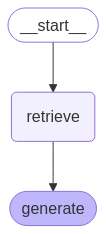

In [46]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
result = graph.invoke({"question": "Who are the data science teaching staff?"})

#print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

 The teaching staff enrolled in the Bachelor's program with a focus on Data Science includes:

* Américo Rio (Invited Assistant Professor)
* Ana Cristina Costa (Associate Professor)
* Artur Varanda (Adjunct Lecturer)
* Augusto Santos (Assistant Professor)
* Bruno Damásio (Assistant Professor)
* Carina Albuquerque (Assistant Professor)
* Carolina Maria Shaul (Adjunct Lecturer)
* Carolina Santos Maximiano (Adjunct Lecturer)
* Carolina Vasconcelos (Invited Teaching Assistant)
* Catarina Neves (Assistant Professor)
* Catarina Palha (Invited Teaching Assistant)
* Dhruv Akshay Pandit (Invited Teaching Assistant)
* Diogo Rasteiro (Research Assistant)
* Fernando Bação (Full Professor)
* Filipe Marques (Professor of the Practice)
* Gonçalo Baptista (Professor of the Practice)
* Helena Guerra (Invited Assistant Professor)
* Ian Scott (Assistant Professor)
* Ivo Bernardo (Adjunct Lecturer)
* Joana Neves (Assistant Professor)
* Jorge Neves (Invited Assistant Professor)
* José Carvalho (Invited Tea

llama_perf_context_print:        load time =  329624.10 ms
llama_perf_context_print: prompt eval time =  329623.59 ms /  3249 tokens (  101.45 ms per token,     9.86 tokens per second)
llama_perf_context_print:        eval time =  153436.76 ms /   461 runs   (  332.83 ms per token,     3.00 tokens per second)
llama_perf_context_print:       total time =  484393.94 ms /  3710 tokens


Answer:  The teaching staff enrolled in the Bachelor's program with a focus on Data Science includes:

* Américo Rio (Invited Assistant Professor)
* Ana Cristina Costa (Associate Professor)
* Artur Varanda (Adjunct Lecturer)
* Augusto Santos (Assistant Professor)
* Bruno Damásio (Assistant Professor)
* Carina Albuquerque (Assistant Professor)
* Carolina Maria Shaul (Adjunct Lecturer)
* Carolina Santos Maximiano (Adjunct Lecturer)
* Carolina Vasconcelos (Invited Teaching Assistant)
* Catarina Neves (Assistant Professor)
* Catarina Palha (Invited Teaching Assistant)
* Dhruv Akshay Pandit (Invited Teaching Assistant)
* Diogo Rasteiro (Research Assistant)
* Fernando Bação (Full Professor)
* Filipe Marques (Professor of the Practice)
* Gonçalo Baptista (Professor of the Practice)
* Helena Guerra (Invited Assistant Professor)
* Ian Scott (Assistant Professor)
* Ivo Bernardo (Adjunct Lecturer)
* Joana Neves (Assistant Professor)
* Jorge Neves (Invited Assistant Professor)
* José Carvalho (Inv

In [48]:
result = graph.invoke({"question": "What is professors Ivo Bernado email?"})

#print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Llama.generate: 60 prefix-match hit, remaining 2750 prompt tokens to eval


 The email address for Ivo Bernardo is ibernardo@novaims.unl.pt.

llama_perf_context_print:        load time =  329624.10 ms
llama_perf_context_print: prompt eval time =  250004.56 ms /  2750 tokens (   90.91 ms per token,    11.00 tokens per second)
llama_perf_context_print:        eval time =    7601.32 ms /    23 runs   (  330.49 ms per token,     3.03 tokens per second)
llama_perf_context_print:       total time =  257678.34 ms /  2773 tokens


Answer:  The email address for Ivo Bernardo is ibernardo@novaims.unl.pt.
